In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

import utils

In [2]:
CODINGS_SIZE = 10

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = utils.load_fashion_mnist_data()
print(f"x_train.shape = {x_train.shape}, x_val.shape = {x_val.shape}")

x_train.shape = (55000, 28, 28), x_val.shape = (5000, 28, 28)


In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs, **kwargs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [5]:
utils.reset_session()

inputs = keras.layers.Input(shape=[28, 28])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(100, activation='selu')(x)
codings_mean = keras.layers.Dense(CODINGS_SIZE)(x)
codings_log_var = keras.layers.Dense(CODINGS_SIZE)(x)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], 
    outputs=[codings_mean, codings_log_var, codings],
    name='variational_encoder'
)
variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape=[CODINGS_SIZE])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(
    inputs=[decoder_inputs], 
    outputs=[outputs],
    name='variational_decoder'
)
variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_autoencoder = keras.models.Model(
    inputs=[inputs], 
    outputs=[reconstructions]
)

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_autoencoder.add_loss(K.mean(latent_loss) / 784.0)

variational_autoencoder.compile(
    loss="binary_crossentropy", 
    optimizer="rmsprop", 
    metrics=[utils.rounded_accuracy]
)
history = variational_autoencoder.fit(
    x_train, x_train, 
    epochs=25, 
    batch_size=128,
    validation_data=(x_val, x_val)
)

Model: "variational_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          117750      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          15100       dense[0][0]                      
________________________________________________________________________________

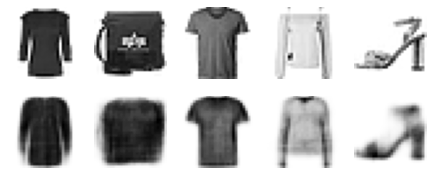

In [6]:
utils.reconstruct(variational_autoencoder, x_val[:5])